In [114]:
import numpy as np, pandas as pd, os, sys
from sklearn.datasets import fetch_mldata
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.base import BaseEstimator, clone

In [112]:
from sklearn.datasets.base import get_data_home 
#print (get_data_home())

In [4]:
mnist = np.load('mnist.npy')

In [35]:
mnist.shape

(70000, 785)

In [19]:
X, y = mnist[:,1:], mnist[:,0]

In [20]:
%matplotlib inline
import matplotlib , matplotlib.pyplot as plt

In [47]:
np.random.seed(1)
rand_digit = np.random.choice(np.arange(len(mnist)))

In [48]:
dig_img = X[rand_digit].reshape(28,28)

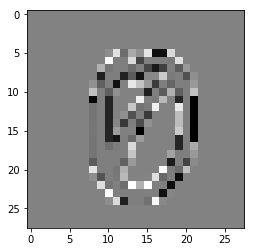

In [49]:
plt.imshow(dig_img, cmap = 'gray', interpolation='none')
plt.show()

In [51]:
print (f'Number on the picture is {y[rand_digit]}')

Number on the picture is 0


In [57]:
unique, counts = np.unique(y, return_counts=True)
print ('Unique number in dataset and their counts')
dict(zip(unique, counts))

Unique number in dataset and their counts


{0: 6903,
 1: 7877,
 2: 6990,
 3: 7141,
 4: 6824,
 5: 6313,
 6: 6876,
 7: 7293,
 8: 6825,
 9: 6958}

In [110]:
train_index = np.random.permutation(int(len(mnist) * 0.75))
mask1 = ~np.isin(list(np.arange(len(mnist) )), train_index)
test_index = np.arange(len(mnist))[mask1]
X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]

In [ ]:
#Random Forest clf
rf_clf = RandomForestClassifier(random_state=1)
y_forest_probs = cross_val_predict(rf_clf, 